# Text classification with a LSTM

## Setup

In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [6]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"This stirring western spins the tale of the famous rifle of the early west that was coveted by one and all. James Stewart is the cowboy who wins the prized Winchester in a shootout, only to lose it in a robbery. The story details Stewart's pursuit of the rifle and a certain man through the film. The rifle changes hands time after time, as though the owner is fated to lose it through violence. The picture has plenty of action and suspense as Stewart closes in on his quarry. A great cast supports Stewart here, namely Stephen McNally, Dan Duryea, Millard Mitchell, John McIntire and Jay C. Flippen. Shelley Winters seems miscast here and the purpose of her role is rather obscure. Tony Curtis and Rock Hudson, teen heartthrobs in later years, have brief but good roles."
 b"At the beginning of the film we watch May and Toots preparing for their trip to London for a visit to their grown children. One can see Toots is not in the best of health, but he goes along. When he dies suddenly

## Creating the text encoder

In [8]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [9]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [10]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11,   1,   1, ...,   0,   0,   0],
       [ 31,   2, 445, ...,   0,   0,   0],
       [432,   2,  20, ...,   0,   0,   0]])

In [11]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"This stirring western spins the tale of the famous rifle of the early west that was coveted by one and all. James Stewart is the cowboy who wins the prized Winchester in a shootout, only to lose it in a robbery. The story details Stewart's pursuit of the rifle and a certain man through the film. The rifle changes hands time after time, as though the owner is fated to lose it through violence. The picture has plenty of action and suspense as Stewart closes in on his quarry. A great cast supports Stewart here, namely Stephen McNally, Dan Duryea, Millard Mitchell, John McIntire and Jay C. Flippen. Shelley Winters seems miscast here and the purpose of her role is rather obscure. Tony Curtis and Rock Hudson, teen heartthrobs in later years, have brief but good roles."
Round-trip:  this [UNK] [UNK] [UNK] the tale of the famous [UNK] of the early [UNK] that was [UNK] by one and all james [UNK] is the [UNK] who [UNK] the [UNK] [UNK] in a [UNK] only to [UNK] it in a [UNK] the story

## Creating the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model from the official tensorflow tutorial page on an RNN.


In [12]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [13]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [14]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 6s 6s/step
[0.00716936]


In [15]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 69ms/step
[0.00716936]


In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [17]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 72s 147ms/step - loss: 0.6377 - accuracy: 0.5816 - val_loss: 0.4791 - val_accuracy: 0.8042
Epoch 2/10
391/391 [==============================] - 31s 78ms/step - loss: 0.3951 - accuracy: 0.8201 - val_loss: 0.3558 - val_accuracy: 0.8385
Epoch 3/10
391/391 [==============================] - 33s 83ms/step - loss: 0.3360 - accuracy: 0.8509 - val_loss: 0.3391 - val_accuracy: 0.8469
Epoch 4/10
391/391 [==============================] - 31s 78ms/step - loss: 0.3223 - accuracy: 0.8585 - val_loss: 0.3352 - val_accuracy: 0.8531
Epoch 5/10
391/391 [==============================] - 33s 84ms/step - loss: 0.3144 - accuracy: 0.8647 - val_loss: 0.3310 - val_accuracy: 0.8531
Epoch 6/10
391/391 [==============================] - 33s 84ms/step - loss: 0.3083 - accuracy: 0.8677 - val_loss: 0.3400 - val_accuracy: 0.8615
Epoch 7/10
391/391 [==============================] - 34s 86ms/step - loss: 0.3055 - accuracy: 0.8690 - val_loss: 0.3280 - val_accuracy

In [18]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 15s 38ms/step - loss: 0.3268 - accuracy: 0.8624
Test Loss: 0.3267515301704407
Test Accuracy: 0.8623600006103516


(0.0, 0.6545967280864715)

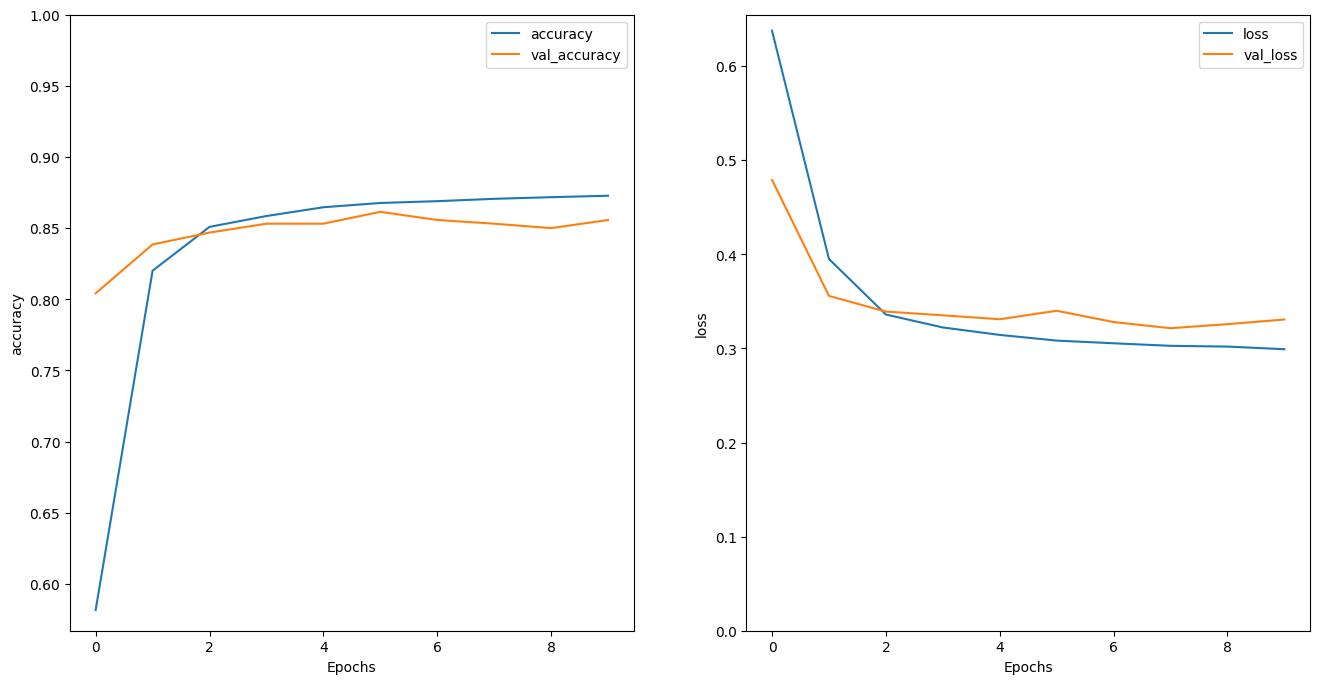

In [19]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [20]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


## Stacking two or more LSTM layers

Image from official tensorflow tutorial:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

In [21]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [23]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 104s 200ms/step - loss: 0.6013 - accuracy: 0.6109 - val_loss: 0.4153 - val_accuracy: 0.8281
Epoch 2/10
391/391 [==============================] - 57s 146ms/step - loss: 0.3675 - accuracy: 0.8394 - val_loss: 0.3694 - val_accuracy: 0.8500
Epoch 3/10
391/391 [==============================] - 58s 149ms/step - loss: 0.3320 - accuracy: 0.8551 - val_loss: 0.3366 - val_accuracy: 0.8417
Epoch 4/10
391/391 [==============================] - 55s 140ms/step - loss: 0.3194 - accuracy: 0.8632 - val_loss: 0.3271 - val_accuracy: 0.8432
Epoch 5/10
391/391 [==============================] - 53s 135ms/step - loss: 0.3109 - accuracy: 0.8646 - val_loss: 0.3488 - val_accuracy: 0.8318
Epoch 6/10
391/391 [==============================] - 54s 137ms/step - loss: 0.3097 - accuracy: 0.8667 - val_loss: 0.3188 - val_accuracy: 0.8547
Epoch 7/10
391/391 [==============================] - 54s 137ms/step - loss: 0.3053 - accuracy: 0.8688 - val_loss: 0.3229 - val_a

In [24]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 22s 56ms/step - loss: 0.3186 - accuracy: 0.8627
Test Loss: 0.31861817836761475
Test Accuracy: 0.8626800179481506


In [25]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-1.8653368]]


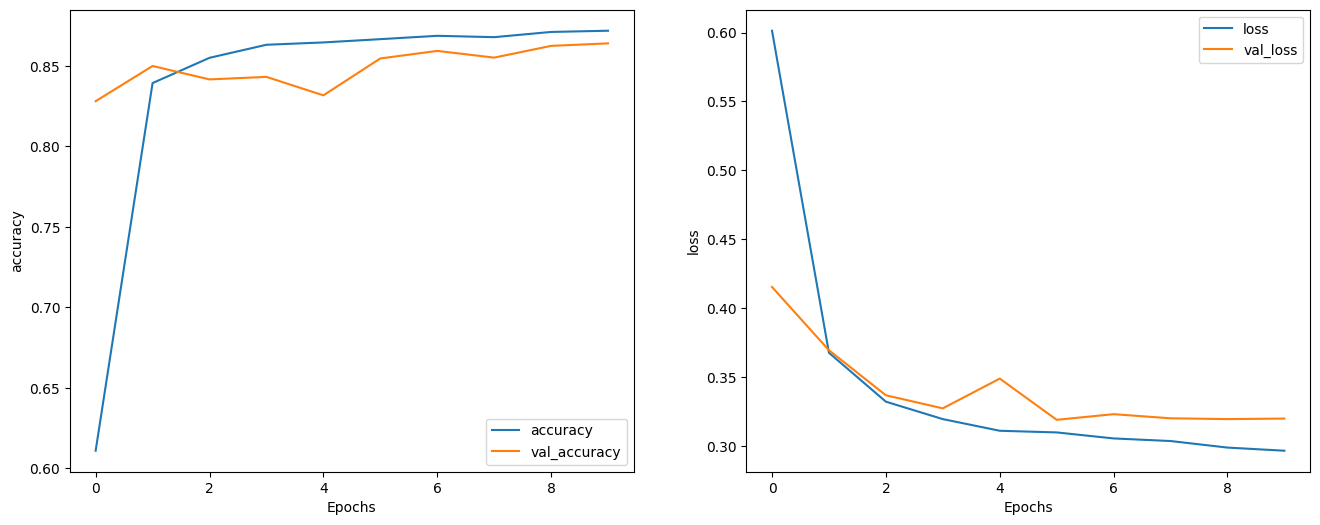

In [26]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
